# Keras 101: Designing your Neural Network - How Many Hidden Layers?

Hopefully you will have followed our walkthrough on the affect of adding more neurons to a single hidden layers.

We stared with the simpliest componant of a neural network the neuron and demonstrated how this describes a linear classifier (Logistic regression). We then saw that for each neuron added to a single hidden layer a new linear representation of your input data can be used in the final output of the neural network. As such with an arbitary number of neurons any continuous function can be approximated, in terms of our classification example this meant that any arbitary decision boundary could be drawn.

At this point a question you may be asking yourself "if a single hidden layer with an arbitary number of neurons can approximate any continuous function, why might we add a second hidden layer?" In reality it is rare to find a problem that requires more than a single hidden layer, ...give some examples... however there are situations in which it is certainly benifitial or even impracticle not to.

In order to begin exploring the effects of more hidden layers we are going to look at a different type of problem know as regression. We are going to build a neural network that aims to learn some complex functions, specifically variations of a 2D gaussian.

# Data Generation

To start we need to import the necessary packages and define a couple of useful functions.

In [1]:
import keras
import numpy as np
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gkern2(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    guass = fi.gaussian_filter(inp, nsig)/kernlen
    max1 = np.amax(guass)
    gauss = guass/max1
    return gauss

def generateGaussianHill(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = gkern2(spacer,sig)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacer)
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def generateGaussianHillValley(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = np.append(gkern2(spacer,9),-1*gkern2(spacer,9),axis=0)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/(2*spacer))
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def plotGaussian(labels,xmin,xmax,ymin,ymax,spacerx,spacery,label):
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacerx)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacery)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    gaus = labels.reshape(X.shape)
    ax.plot_surface(X, Y, gaus)
    fig.suptitle(label)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
def lossPlot(loss,label):
    
    epoch = np.arange(0, len(loss))
    plt.plot(epoch,loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


Using TensorFlow backend.


For this first example we will be attempting to produce a neural netowrk that aims to approximate a 2d gaussian. Our training data and a plot of our target function can be found by running the code below.

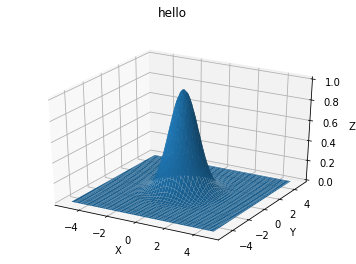

In [2]:
features, labels = generateGaussianHill(-5.0,5.0,-5.0,5.0,100,9)
plotGaussian(labels,-5.0,5.0,-5.0,5.0,100,100,"hello")

In order to learn this function we will input each x and y co-ordinate into the network, the output of the network will be the z height for that pair of x and y co-ordinates. Therefor our features array will consist of an array of x and y co-ordiantes and our labels array will correspond to the z height for each x and y pair.

We will repeat our experiment from the previous notebook for this dataset. We will build a number of neural networks with incresing number of neurons in a single hidden layer. When we run this code a summary of each network will be output, note the number of parameters for each network.

In [10]:
layers = []
layers.append(keras.layers.Dense(5, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model1 = keras.Sequential(layers)
print(model1.summary())

layers = []
layers.append(keras.layers.Dense(15, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model2 = keras.Sequential(layers)
print(model2.summary())

layers = []
layers.append(keras.layers.Dense(45, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model3 = keras.Sequential(layers)
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 15)                45        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 16        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (t

Let us now train each network and plot the log of loss for each model.

In [11]:
model1.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history1 = model1.fit(features, labels, batch_size=features.shape[0],epochs=6000, verbose=0)
model2.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history2 = model2.fit(features, labels, batch_size=features.shape[0],epochs=6000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history3 = model3.fit(features, labels, batch_size=features.shape[0],epochs=6000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history4 = model3.fit(features, labels, batch_size=features.shape[0],epochs=6000, verbose=0)

history3 = history3.history['loss'] + history4.history['loss']

lossPlot(np.log(history1.history['loss']),"model 1")
lossPlot(np.log(history2.history['loss']),"model 2")
lossPlot(np.log( history3.history['loss'] + history4.history['loss']),"model 3")
plt.show()
print("Final Loss for model3", history4[-1])

TypeError: unsupported operand type(s) for +: 'History' and 'History'

We can can see that increasing the number of neurons drastically reduces the final loss of the model. Let's have a look at the function each network has learnt.

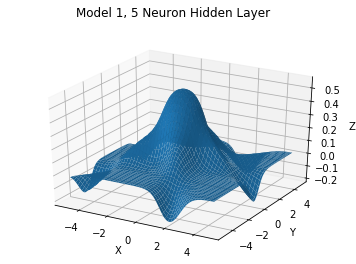

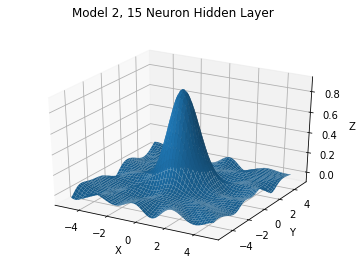

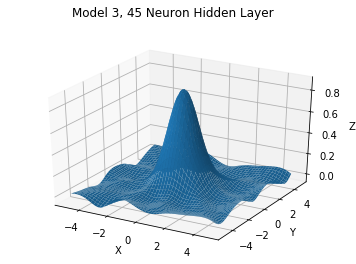

In [7]:
z = model1.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 1, 5 Neuron Hidden Layer")
z = model2.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 2, 15 Neuron Hidden Layer")
z = model3.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 3, 45 Neuron Hidden Layer")

It is clear that increasing the number of neurons drastically brings the learnt function closer to the target, specifically it takes reletively few neurons to reproduce produce the signiture bump in the function however reproducing the flat surounding area is very difficult for a few number of neurons and requires a large number of neurons to produce anything close to the target function.

For us the interesting number here to take note of is the number of parameters in the network for a single hidden layer of 45 neurons there are 181 parameters in the network or 181 weights to be calculated for each iteration in the network.

Now let us take a look at a neural network model with two hidden layers that contain much fewer neurons in each than the previous examples, the first contains 4 and the second contains 3. 

In [28]:
layers = []
layers.append(keras.layers.Dense(4, input_dim = 2, activation="sigmoid"))
layers.append(keras.layers.Dense(3, input_dim = 2, activation="sigmoid"))

layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 4         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
None


Let us now train this model and plot the loss to check for convergence.

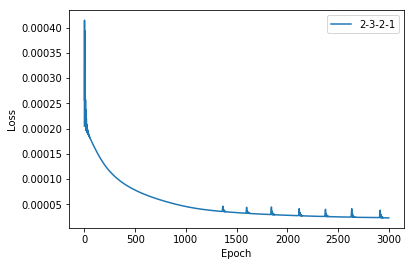

In [31]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history2 = model.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)

lossPlot(history.history['loss']+history2.history['loss'],"2-3-2-1")
plt.show()
print("Final Loss:",history2.history['loss'][-1])


Finally we shall plot the resulting function the network has learnt.

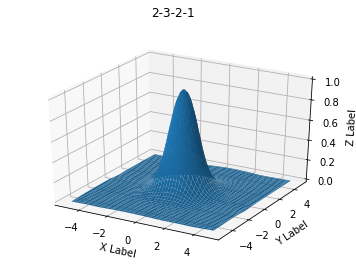

In [32]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,'2-3-2-1')

As you can see the final function looks much closer to the target function. You may have already noted that the number of parameters (31) is much less than that of the network with a single hidden layer that produced a function even close to that with two hidden layers.

This highlights the first benifit of adding more hidden layers to your nerual network. Adding a second hidden layer allows you to produce a netowrk that performs equivelently to a network with many more parameters and a single hidden layer.

The question now is, why? 

Hidden_layer_output = K.function([model.layers[0].input],[model.layers[0].output])
out = Hidden_layer_output(features)[0]

out1 = out[:,[0]].reshape(xx.shape)
out2 = out[:,[1]].reshape(xx.shape)

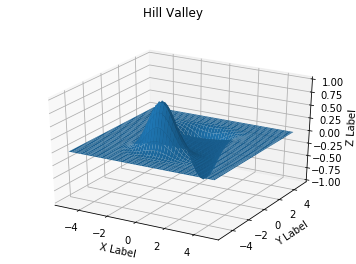

In [74]:
features, labels = generateGaussianHillValley(-5.0,5.0,-5.0,5.0,100,9)
plotGaussian(labels,-5.0,5.0,-5.0,5.0,100,200,"Hill Valley")

In [75]:
layers = []
layers.append(keras.layers.Dense(50, input_dim = 2, activation="tanh"))
layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
None


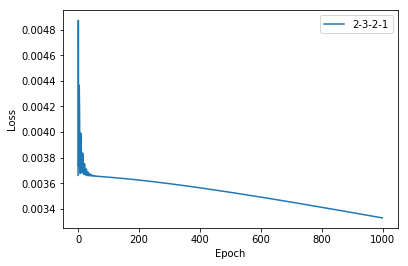

In [83]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)
lossPlot(history.history['loss'],"2-3-2-1")
plt.show()

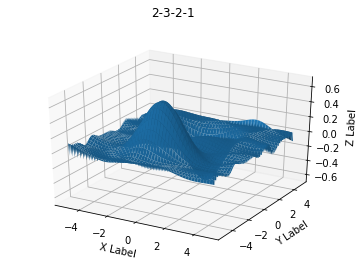

In [84]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,200,'2-3-2-1')

In [46]:
layers = []
layers.append(keras.layers.Dense(20, input_dim = 2, activation="tanh"))
layers.append(keras.layers.Dense(4, input_dim = 2, activation="tanh"))

layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 84        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
None


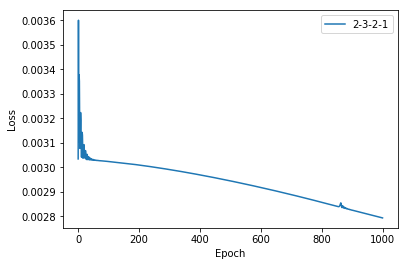

In [86]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)
lossPlot(history.history['loss'],"2-3-2-1")
plt.show()

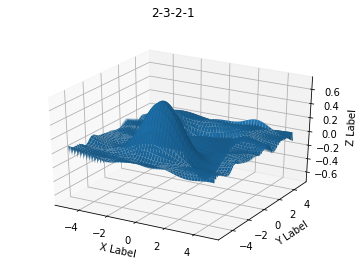

In [88]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,200,'2-3-2-1')

(300, 2)
(1200,)


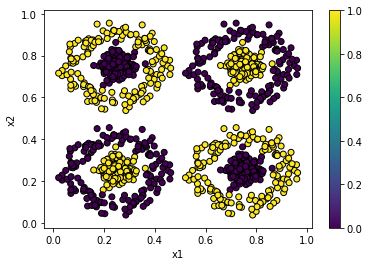

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


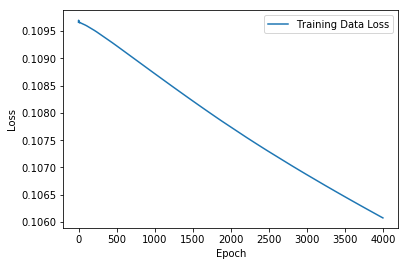

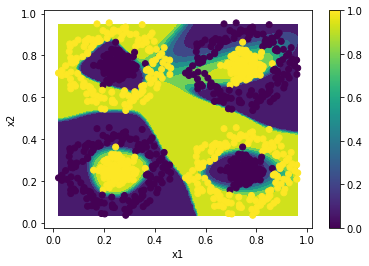

In [10]:
from sklearn.datasets import make_moons, make_circles

dataset_circle = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle1 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle2 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle3 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)

features_circle = dataset_circle[0]
labels_circle = dataset_circle[1]
labels_circle1 =labels_circle.copy()

features_circle[:,0] = (features_circle[:,0]+1.5)/6.0
features_circle[:,1] = (features_circle[:,1]+1.5)/6.0

features_circle2 = features_circle.copy()
features_circle2[:,0] = features_circle[:,0]+0.5

oneFilter = labels_circle ==1
zeroFilter = labels_circle ==0
labels_circle2 = labels_circle.copy()
labels_circle2[oneFilter] = 0
labels_circle2[zeroFilter] = 1


features_circle3 = features_circle.copy()
features_circle3[:,1] = features_circle[:,1]+0.5

features_circle4 = features_circle.copy()
features_circle4[:,1] = features_circle[:,1]+0.5
features_circle4[:,0] = features_circle[:,0]+0.5



print(features_circle.shape)
features_circle = np.append(features_circle,features_circle2, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle3, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle4, axis=0)
labels_circle = np.append(labels_circle,labels_circle1, axis=0)
print(labels_circle.shape)

x1_min = np.amin(features_circle[:,0])
x1_max = np.amax(features_circle[:,0])
x2_min = np.amin(features_circle[:,1])
x2_max = np.amax(features_circle[:,1])

plt.scatter(features_circle[:,0],features_circle[:,1],edgecolor="black",linewidth=1,c=labels_circle)
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()


layers = []
layers.append(keras.layers.Dense(10, input_dim = 2, activation="sigmoid"))

layers.append(keras.layers.Dense(1, activation="sigmoid"))

model = keras.Sequential(layers)
print(model.summary())
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=18000, verbose=0)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=4000, verbose=0)

loss = history.history['loss']
epoch = np.arange(0, len(loss))

plt.plot(epoch,loss, label='Training Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
xx, yy = np.meshgrid(np.arange(x1_min,x1_max,0.01),np.arange(x2_min,x2_max,0.01))

z = model.predict(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)

plt.contourf(xx,yy,z)
plt.scatter(features_circle[:,0],features_circle[:,1],c= labels_circle)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()